<img src='../img/joint_school_banner_2.png' alt='joint school banner' align='right' width='100%'></img>

<br>

# Metop-A/B GOME-2 Tropospheric NO<sub>2</sub> Anomaly map (August 2015)

### About

The Global Ozone Monitoring Experiment 2 (GOME-2) is an optical spectrometer used for the long-term monitoring of atmospheric trace gas constituents. The GOME-2 instrument has been in orbit on Metop-A since October 2006 until 2020 and on Metop-B since September 2012. 

This workflow shows how to produce a anomaly map of Metop-A/B GOME-2 Level 2 data of tropospheric NO<sub>2</sub> for a specific month in 2015 compared to the longterm average of tropospheric NO<sub>2</sub> based on Metop-A/B GOME-2 Level 3 data between 2007 and 2017. The first step is to create longterm monthly mean for each month from GOME-2 Level 3 data. The last step is the creation of the anomaly map.

Find more information about the instrument in the [GOME-2 NO2 (and other trace gases) Product User guides](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf) and the Level 3 data on the [AC SAF website](https://acsaf.org/datarecords/no2_h2o_tcdr.php).

### Basic Facts

> **Spatial resolution**: `0.25° x 0.25°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `Monthly` <br>
> **Temporal coverage**: `since 2007 to 2017` <br>
> **Data format**: `NetCDF`


### How to access the data

The GOME-2 Level 3 tropospheric NO<sub>2</sub> data can be downloaded `via FTP` using this [download URL](ftp://acsaf.eoc.dlr.de). You can use an FTP client such as [FileZilla](https://filezilla-project.org/) to access the files. 

You need to first [register for an account](https://acsaf.org/registration_form.html) with AC SAF and log-in using the credentials you will receive in an email after registration.

### Module Outline
- [Load Metop-A/B GOME-2 Level 3 data and create longterm monthly mean](#level3_anomaly_map)
- [Generate anomaly map based on the longterm mean of tropospheric NO<sub>2</sub>](#anomaly_map)

#### Load required libraries

In [1]:
import glob
import os

import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.feature as cfeature

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='level3_anomaly_map'></a>Load Metop-A/B GOME-2 Level 3 data and create longterm monthly mean

GOME-2 Level 3 data are available from February 2007 to November 2017. From this longterm time-series, you can create a longterm monthly mean that can be used as a basis to calculate anomalies.

#### Load the Metop-A/B GOME-2 Level 3 data files as `xarray.DataArray` with the function `xarray.open_mfdataset()`

The Metop-A/B GOME-2 Level 3 data are disseminated in `netCDF`. The function `xarray.open_mfdataset()` can be used to load the data for all months at once. Use `time` for the keyword argument `concat_dim`.

In [3]:
gome_l3 = xr.open_mfdataset('../../eodata/training_school/gome2/level3/no2-metop-a-b/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
gome_l3

<xarray.Dataset>
Dimensions:          (time: 130, latitude: 720, longitude: 1440)
Dimensions without coordinates: time, latitude, longitude
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

Above, you can see that the `xarray.Dataset` has three dimensions (`latitude`, `longitude` and `time`), but the dimensions do not have coordinates. However, you would need the coordinate information for plotting.

As a next step, we load one single GOME-2 Level 3 file and retrieve the `latitude` and `longitude` coordinates. You can use this information to assign the coordinates to the `xarray.Dataset` above.

In [4]:
ds = xr.open_dataset('../../eodata/training_school/gome2/level3/no2-metop-a-b/GOME_NO2_Global_200702_METOPA_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 720, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Data variables:
     *empty*
 Attributes:
     description:  Level 3 NO2 data
     Conventions:  CF-1.6,
 <xarray.DataArray 'latitude' (latitude: 720)>
 array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
 Attributes:
     standard_name:  latitude
     long_name:      latitude_Centre, center of the grid box
     units:          degrees_north,
 <xarray.DataArray 'longitude' (longitude: 1440)>
 array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
       dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     standard_name:  longitude
     

#### Assign coordinates to the dimensions `latitude`, `longitude` and `time`

With the function `pandas.date_range` from the pandas library, you can build a list of monthly time coordinates from February 2007 to November 2017.

In [5]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', length=130, freq=None)

Use the function `xarray.assign_coords()` to assign `latitude`, `longitude` and `time` coordinates to the `gome_l3`  `xarray.Dataset`.

In [6]:
# Assign values to Dataset dimension
gome_l3_assigned = gome_l3.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
gome_l3_assigned

<xarray.Dataset>
Dimensions:          (time: 130, latitude: 720, longitude: 1440)
Coordinates:
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time             (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

#### Create the longterm spatial average for each month

Use the `xarray.groupby().mean()` function to calculate the longterm mean of Tropospheric NO<sub>2</sub> for each month. The resulting data array has 12 time entries, one for each month.

In [7]:
l3_spatial_mean = gome_l3_assigned.groupby('time.month').mean()
l3_spatial_mean

<xarray.Dataset>
Dimensions:          (month: 12, latitude: 720, longitude: 1440)
Coordinates:
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NO2total         (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

#### Retrieve the data variable `NO2Trop` from the dataset

Select the data variable `NO2Trop` as the variable of interest.

In [8]:
no2_l3_spatial_mean = l3_spatial_mean.NO2trop
no2_l3_spatial_mean

<xarray.DataArray 'NO2trop' (month: 12, latitude: 720, longitude: 1440)>
dask.array<concatenate, shape=(12, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### Optional: Save the Metop-A/B GOME-2 Level 3 climatology as `netCDF` 

In [9]:
no2_l3_spatial_mean.to_netcdf('../../no2_l3_climatology.nc', 'w')

## <a id='region_list'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for `Europe`, the `Po valley` in Italy, the `Hubei region` in China and in `Southeast Asia`, showing Malaysia and part of Indonesia. The dictionaries are stored in a list.

In [10]:
# Europe extent
eur_extent={'name': 'eur_extent',
    'lonmin':-10.0,
            'lonmax':30.0,
            'latmin':35.0,
            'latmax':60.0}

# Italy (Po Valley, Milano)
povalley_extent={'name': 'povalley_extent',
    'lonmin':7.0,
            'lonmax':13.0,
            'latmin':44.0,
            'latmax':47.0}

# China (Hubei, Wuhan)
hubei_extent={'name': 'hubei_extent',
    'lonmin':112.0,
            'lonmax':118.0,
            'latmin':28.0,
            'latmax':33.0}

# Southeast Asia (part)
sea_extent={'name': 'sea_extent',
    'lonmin':95.0,
            'lonmax':120.0,
            'latmin':-10.0,
            'latmax':10.0}

region_list=[eur_extent,
             povalley_extent,
            hubei_extent,
            sea_extent]

#### Visualize the longterm average of tropospheric NO<sub>2</sub> for a specific month

You can use the data array above and select a specific month and visualize it for Southeast Asia. You can use the function `xarray.isel(month=x)` to select a specific month. For example, with `x=3` you can visualize the longterm average for March.

Note: Multiplying the vmax and vmin values with 1e<sup>+16</sup> improves the readibility of the map legend. As vmin is already 0, we do not need to multiply it.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Gridded level 3 data of tropospheric NO2 - August Average'}>)

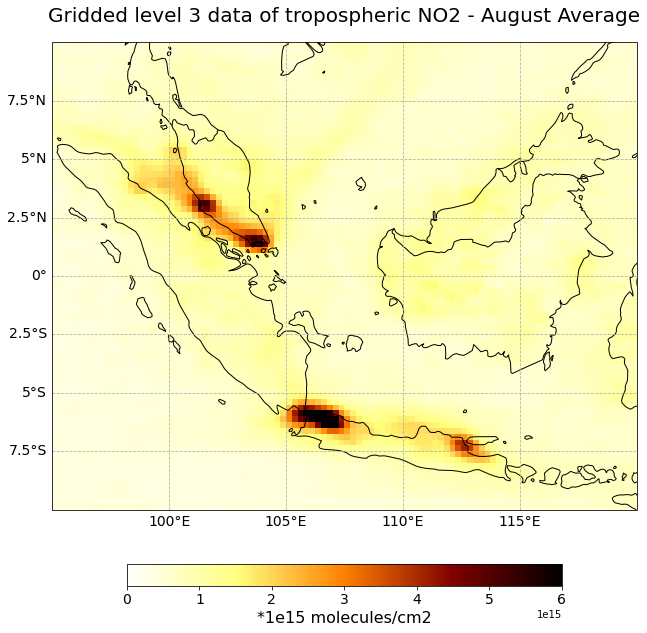

In [12]:
visualize_pcolormesh(data_array=no2_l3_spatial_mean.isel(month=7), 
                     longitude=no2_l3_spatial_mean.longitude, 
                     latitude=no2_l3_spatial_mean.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit='*1e15 molecules/cm2', 
                     long_name='Gridded level 3 data of tropospheric NO2 - August Average', 
                     vmin=0, 
                     vmax=6*1e+15, 
                     lonmin=region_list[3]['lonmin'],
                     lonmax=region_list[3]['lonmax'], 
                     latmin=region_list[3]['latmin'], 
                     latmax=region_list[3]['latmax'], 
                     set_global=False)

## <a id='anomaly_map'></a> Generate anomaly map based on the longterm mean of Tropospheric NO<sub>2</sub>

#### Compute the anomaly map

Let us compute the anomaly map for August 2015, when several large wildfires were burning in Indonesia. You can calculate the anomaly of August 2015 compared to the longterm average of tropospheric NO<sub>2</sub> by subtracting the longterm average from the average values of this year.

In [13]:
gome2_no2_201508_anomaly = gome_l3_assigned.sel(time='2015-08-01') - no2_l3_spatial_mean.sel(month=7)
gome2_no2_201508_anomaly

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440)
Coordinates:
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
    time             datetime64[ns] 2015-08-01
    month            int64 7
Data variables:
    NO2total         (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    NO2total_err     (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    NO2total_stddev  (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    NO2trop          (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    NO2trop_err      (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    NO2trop_stddev   (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    nobs             (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>

#### Visualize the anomaly map 

The last step is to visualize the anomaly map. You can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) again. 

Note: Multiplying the vmax and vmin values with 1e<sup>+15</sup> improves the readibility of the map legend. 

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'August 2015 anomaly of tropospheric NO2 - based on longterm mean (2007-2017)'}>)

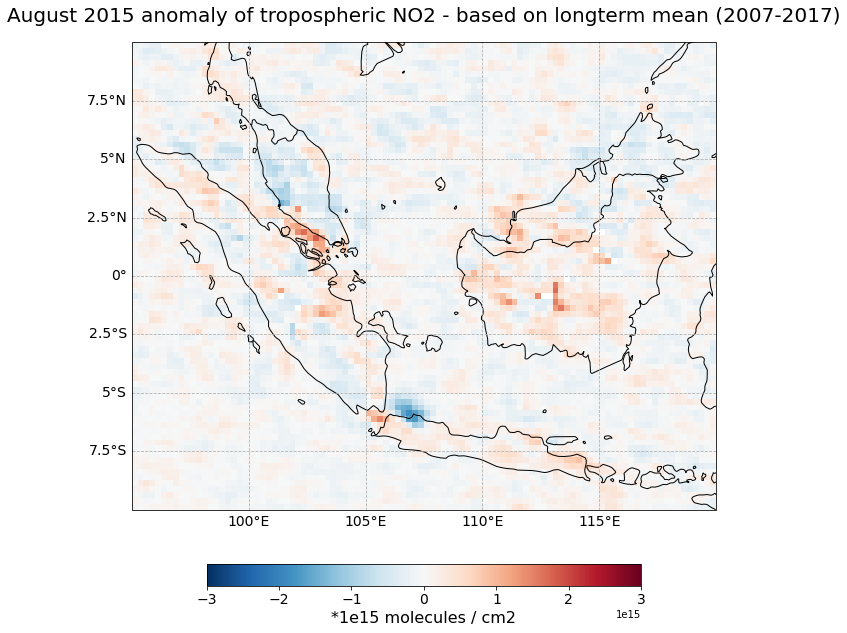

In [15]:
visualize_pcolormesh(data_array=gome2_no2_201508_anomaly['NO2trop'], 
                     longitude=gome2_no2_201508_anomaly.longitude, 
                     latitude=gome2_no2_201508_anomaly.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='RdBu_r', 
                     unit='*1e15 molecules / cm2', 
                     long_name='August 2015 anomaly of tropospheric NO2 - based on longterm mean (2007-2017)', 
                     vmin=-3*1e15, 
                     vmax=3*1e+15, 
                     lonmin=region_list[3]['lonmin'],
                     lonmax=region_list[3]['lonmax'], 
                     latmin=region_list[3]['latmin'], 
                     latmax=region_list[3]['latmax'], 
                     set_global=False)

<br>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>.</p>